### Baseline

In [3]:
!pip install catboost==1.0.3
!pip install lightgbm==3.2.1

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

sns.set()

In [172]:
import pandas as pd
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')


In [173]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity

In [174]:
for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

In [175]:
print('Missing data in train: {:.5f}%'.format(df_train.isnull().sum().sum() / (df_train.shape[0] * df_train.shape[1]) * 100))
print('Missing data in test: {:.5f}%'.format(df_test.isnull().sum().sum() / (df_test.shape[0] * df_test.shape[1]) * 100))

Missing data in train: 0.00000%
Missing data in test: 0.00000%


In [176]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|██████████| 433/433 [00:13<00:00, 31.72it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float64(399), int64(4)
memory usage: 1.3 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float64(399), int64(3)
memory usage: 537.4 MB


(None, None)

In [177]:
month_length = 3600 * 24 * 30

In [178]:
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
print('Validation set 0 length:', len(fold0_idx))
print('Validation set 1 length:', len(fold1_idx))
print('Validation set 2 length:', len(fold2_idx))
print('Validation set 3 length:', len(fold3_idx))

Validation set 0 length: 134339
Validation set 1 length: 89399
Validation set 2 length: 92189
Validation set 3 length: 101632


In [179]:
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [180]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_train.shape, df_test.shape

((417559, 432), (172981, 431))

In [181]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.292695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31720
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 429


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.886153
[200]	valid_0's auc: 0.895165
[300]	valid_0's auc: 0.898299
[400]	valid_0's auc: 0.898691
[500]	valid_0's auc: 0.899892
[600]	valid_0's auc: 0.89946
[700]	valid_0's auc: 0.899717
Early stopping, best iteration is:
[550]	valid_0's auc: 0.900222


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.543623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34599
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 429


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.912209
[200]	valid_0's auc: 0.920382
[300]	valid_0's auc: 0.924523
[400]	valid_0's auc: 0.925763
[500]	valid_0's auc: 0.926387
[600]	valid_0's auc: 0.926487
[700]	valid_0's auc: 0.924851
Early stopping, best iteration is:
[553]	valid_0's auc: 0.926804


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.528321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34496
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 429


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.914083
[200]	valid_0's auc: 0.922216
[300]	valid_0's auc: 0.921631
Early stopping, best iteration is:
[186]	valid_0's auc: 0.922673


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.559777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34578
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 429


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.8989
[200]	valid_0's auc: 0.905456
[300]	valid_0's auc: 0.904297
Early stopping, best iteration is:
[197]	valid_0's auc: 0.905589
Fold 0, AUC-ROC: 0.90022
Fold 1, AUC-ROC: 0.92680
Fold 2, AUC-ROC: 0.92267
Fold 3, AUC-ROC: 0.90559
CV AUC-ROC: 0.91382
Wall time: 3min 43s


In [182]:
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3
0,TransactionAmt,836,790,206,195
1,ProductCD,32,37,30,34
2,card1,1021,1047,300,324
3,card2,862,783,221,223
4,card3,99,98,63,49


In [183]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

,feature,fold_0,fold_1,fold_2,fold_3,average
0,TransactionAmt,836,790,206,195,506.75
1,ProductCD,32,37,30,34,33.25
2,card1,1021,1047,300,324,673.00
3,card2,862,783,221,223,522.25
4,card3,99,98,63,49,77.25


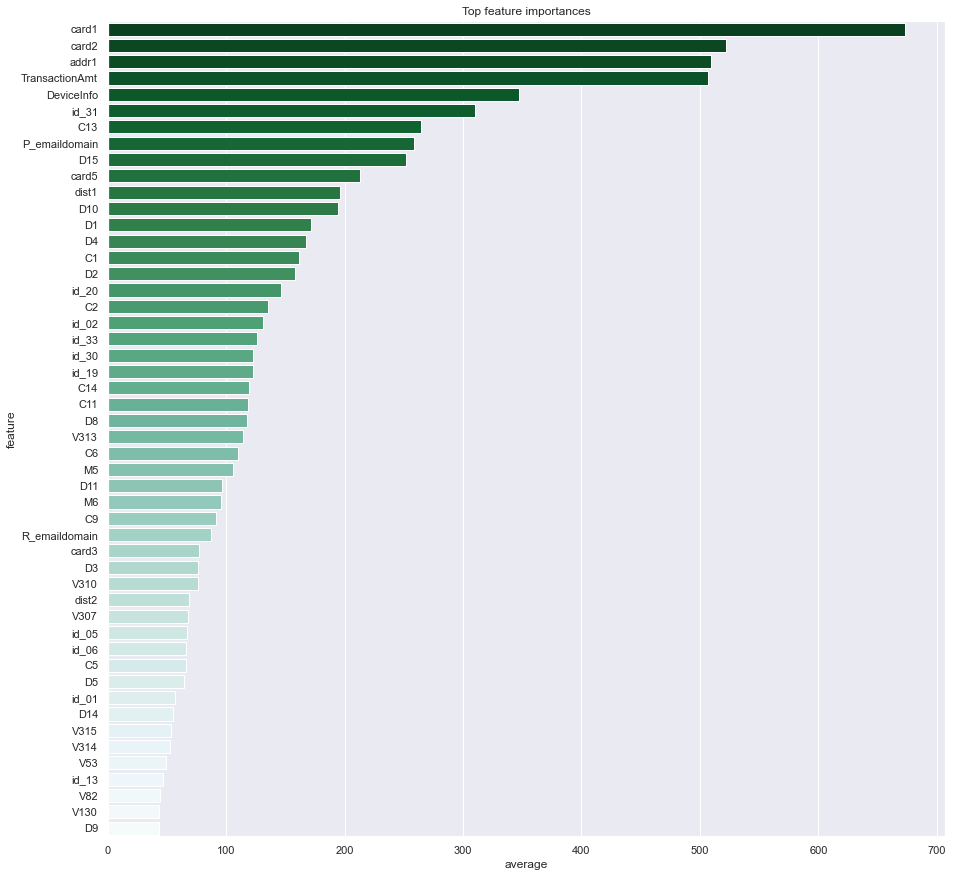

In [184]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

In [185]:
feat = feature_importances.sort_values(by='average', ascending=False)
feat.shape

(431, 6)

In [186]:
feat = feat['feature']
for i in range(200):
    feat.drop(labels=[i], axis=0, inplace = True)

In [187]:
feat = feat.tolist()
len(feat)

231

In [188]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity

for col in df_train.columns.drop('isFraud'):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)
        


In [189]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

df_train.info(), df_test.info()

100%|██████████| 433/433 [00:14<00:00, 30.87it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float64(399), int64(4)
memory usage: 1.3 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float64(399), int64(3)
memory usage: 537.4 MB


(None, None)

In [190]:
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
print('Validation set 0 length:', len(fold0_idx))
print('Validation set 1 length:', len(fold1_idx))
print('Validation set 2 length:', len(fold2_idx))
print('Validation set 3 length:', len(fold3_idx))

Validation set 0 length: 134339
Validation set 1 length: 89399
Validation set 2 length: 92189
Validation set 3 length: 101632


In [191]:
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [192]:
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

In [193]:
for i in range(231):
    df_train.drop([str(feat[i])], axis=1, inplace=True)
    df_test.drop([str(feat[i])], axis=1, inplace=True)

In [194]:
df_train.shape

(417559, 201)

#### Поэкспериментрируем с гиперпараметрами

In [196]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12287
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.882862
[200]	valid_0's auc: 0.88878
[300]	valid_0's auc: 0.892161
[400]	valid_0's auc: 0.894377
[500]	valid_0's auc: 0.894835
[600]	valid_0's auc: 0.895632
[700]	valid_0's auc: 0.895569
[800]	valid_0's auc: 0.895075
[900]	valid_0's auc: 0.893561
Early stopping, best iteration is:
[709]	valid_0's auc: 0.8959


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13603
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.913856
[200]	valid_0's auc: 0.920731
[300]	valid_0's auc: 0.924801
[400]	valid_0's auc: 0.92537
[500]	valid_0's auc: 0.926697
[600]	valid_0's auc: 0.926914
[700]	valid_0's auc: 0.926996
[800]	valid_0's auc: 0.927059
Early stopping, best iteration is:
[610]	valid_0's auc: 0.927418


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.181631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13606
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.918109
[200]	valid_0's auc: 0.923458
[300]	valid_0's auc: 0.926115
[400]	valid_0's auc: 0.926183
[500]	valid_0's auc: 0.927131
[600]	valid_0's auc: 0.926593
Early stopping, best iteration is:
[488]	valid_0's auc: 0.927182


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.197499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13596
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.898996
[200]	valid_0's auc: 0.905224
[300]	valid_0's auc: 0.905748
[400]	valid_0's auc: 0.905648
Early stopping, best iteration is:
[241]	valid_0's auc: 0.906325
Fold 0, AUC-ROC: 0.89590
Fold 1, AUC-ROC: 0.92742
Fold 2, AUC-ROC: 0.92718
Fold 3, AUC-ROC: 0.90632
CV AUC-ROC: 0.91421
Wall time: 2min 33s


In [197]:
%%time

#кол-во деревьев увеличено
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 5000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12287
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.882862
[200]	valid_0's auc: 0.88878
[300]	valid_0's auc: 0.892161
[400]	valid_0's auc: 0.894377
[500]	valid_0's auc: 0.894835
[600]	valid_0's auc: 0.895632
[700]	valid_0's auc: 0.895569
[800]	valid_0's auc: 0.895075
[900]	valid_0's auc: 0.893561
Early stopping, best iteration is:
[709]	valid_0's auc: 0.8959


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.188110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13603
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.913856
[200]	valid_0's auc: 0.920731
[300]	valid_0's auc: 0.924801
[400]	valid_0's auc: 0.92537
[500]	valid_0's auc: 0.926697
[600]	valid_0's auc: 0.926914
[700]	valid_0's auc: 0.926996
[800]	valid_0's auc: 0.927059
Early stopping, best iteration is:
[610]	valid_0's auc: 0.927418


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13606
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.918109
[200]	valid_0's auc: 0.923458
[300]	valid_0's auc: 0.926115
[400]	valid_0's auc: 0.926183
[500]	valid_0's auc: 0.927131
[600]	valid_0's auc: 0.926593
Early stopping, best iteration is:
[488]	valid_0's auc: 0.927182


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.194962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13596
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.898996
[200]	valid_0's auc: 0.905224
[300]	valid_0's auc: 0.905748
[400]	valid_0's auc: 0.905648
Early stopping, best iteration is:
[241]	valid_0's auc: 0.906325
Fold 0, AUC-ROC: 0.89590
Fold 1, AUC-ROC: 0.92742
Fold 2, AUC-ROC: 0.92718
Fold 3, AUC-ROC: 0.90632
CV AUC-ROC: 0.91421
Wall time: 2min 46s


In [207]:
%%time

#увеличен early_stopping_rounds
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 5000,
    'seed': 13,
    'learning_rate': 0.1,
    'early_stopping_rounds': 800,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12287
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 800 rounds
[100]	valid_0's auc: 0.882862
[200]	valid_0's auc: 0.88878
[300]	valid_0's auc: 0.892161
[400]	valid_0's auc: 0.894377
[500]	valid_0's auc: 0.894835
[600]	valid_0's auc: 0.895632
[700]	valid_0's auc: 0.895569
[800]	valid_0's auc: 0.895075
[900]	valid_0's auc: 0.893561
[1000]	valid_0's auc: 0.893336
[1100]	valid_0's auc: 0.891409
[1200]	valid_0's auc: 0.889862
[1300]	valid_0's auc: 0.888431
[1400]	valid_0's auc: 0.887517
[1500]	valid_0's auc: 0.886887
Early stopping, best iteration is:
[709]	valid_0's auc: 0.8959


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13603
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 800 rounds
[100]	valid_0's auc: 0.913856
[200]	valid_0's auc: 0.920731
[300]	valid_0's auc: 0.924801
[400]	valid_0's auc: 0.92537
[500]	valid_0's auc: 0.926697
[600]	valid_0's auc: 0.926914
[700]	valid_0's auc: 0.926996
[800]	valid_0's auc: 0.927059
[900]	valid_0's auc: 0.926911
[1000]	valid_0's auc: 0.926898
[1100]	valid_0's auc: 0.926341
[1200]	valid_0's auc: 0.925957
[1300]	valid_0's auc: 0.925463
[1400]	valid_0's auc: 0.925239
[1500]	valid_0's auc: 0.925008
[1600]	valid_0's auc: 0.924588
Early stopping, best iteration is:
[843]	valid_0's auc: 0.927489


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.232605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13606
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 800 rounds
[100]	valid_0's auc: 0.918109
[200]	valid_0's auc: 0.923458
[300]	valid_0's auc: 0.926115
[400]	valid_0's auc: 0.926183
[500]	valid_0's auc: 0.927131
[600]	valid_0's auc: 0.926593
[700]	valid_0's auc: 0.926029
[800]	valid_0's auc: 0.925104
[900]	valid_0's auc: 0.924856
[1000]	valid_0's auc: 0.924126
[1100]	valid_0's auc: 0.924301
[1200]	valid_0's auc: 0.923481
Early stopping, best iteration is:
[488]	valid_0's auc: 0.927182


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13596
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 199


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 800 rounds
[100]	valid_0's auc: 0.898996
[200]	valid_0's auc: 0.905224
[300]	valid_0's auc: 0.905748
[400]	valid_0's auc: 0.905648
[500]	valid_0's auc: 0.904909
[600]	valid_0's auc: 0.904057
[700]	valid_0's auc: 0.904024
[800]	valid_0's auc: 0.903643
[900]	valid_0's auc: 0.901855
[1000]	valid_0's auc: 0.901061
Early stopping, best iteration is:
[241]	valid_0's auc: 0.906325
Fold 0, AUC-ROC: 0.89590
Fold 1, AUC-ROC: 0.92749
Fold 2, AUC-ROC: 0.92718
Fold 3, AUC-ROC: 0.90632
CV AUC-ROC: 0.91422
Wall time: 5min 13s


In [218]:
#эти изменения не дали плодов

In [212]:
%%time
#другой boosting_type
params = {
    'objective': 'binary',
    'boosting_type': 'goss',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12287
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.886609
[200]	valid_0's auc: 0.894095
[300]	valid_0's auc: 0.89698
[400]	valid_0's auc: 0.899743
[500]	valid_0's auc: 0.899472
[600]	valid_0's auc: 0.899682
Early stopping, best iteration is:
[433]	valid_0's auc: 0.900429


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13603
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.913651
[200]	valid_0's auc: 0.922183
[300]	valid_0's auc: 0.925589
[400]	valid_0's auc: 0.92669
[500]	valid_0's auc: 0.926983
[600]	valid_0's auc: 0.927242
[700]	valid_0's auc: 0.928026
[800]	valid_0's auc: 0.928582
[900]	valid_0's auc: 0.928482
[1000]	valid_0's auc: 0.928755
[1100]	valid_0's auc: 0.928728
[1200]	valid_0's auc: 0.928473
Early stopping, best iteration is:
[1050]	valid_0's auc: 0.929293


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13606
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.917822
[200]	valid_0's auc: 0.926359
[300]	valid_0's auc: 0.929163
[400]	valid_0's auc: 0.929404
[500]	valid_0's auc: 0.929518
[600]	valid_0's auc: 0.929076
Early stopping, best iteration is:
[458]	valid_0's auc: 0.930409


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13596
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.901413
[200]	valid_0's auc: 0.908349
[300]	valid_0's auc: 0.909643
[400]	valid_0's auc: 0.911204
[500]	valid_0's auc: 0.911082
[600]	valid_0's auc: 0.910905
[700]	valid_0's auc: 0.909871
Early stopping, best iteration is:
[573]	valid_0's auc: 0.911555
Fold 0, AUC-ROC: 0.90043
Fold 1, AUC-ROC: 0.92929
Fold 2, AUC-ROC: 0.93041
Fold 3, AUC-ROC: 0.91156
CV AUC-ROC: 0.91792
Wall time: 4min 14s


In [237]:
%%time

#ограниченим вложенность
params = {
    'objective': 'binary',
    'boosting_type': 'goss',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'max_depth': 15,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12287
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.8881
[200]	valid_0's auc: 0.893829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's auc: 0.898737
[400]	valid_0's auc: 0.899786
[500]	valid_0's auc: 0.900358
[600]	valid_0's auc: 0.899293
[700]	valid_0's auc: 0.898645
Early stopping, best iteration is:
[520]	valid_0's auc: 0.900503


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13603
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.913609
[200]	valid_0's auc: 0.921957
[300]	valid_0's auc: 0.926104
[400]	valid_0's auc: 0.927182
[500]	valid_0's auc: 0.926532
[600]	valid_0's auc: 0.926467
Early stopping, best iteration is:
[410]	valid_0's auc: 0.927518


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13606
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.915714
[200]	valid_0's auc: 0.923625
[300]	valid_0's auc: 0.925695
[400]	valid_0's auc: 0.926495
[500]	valid_0's auc: 0.928035
[600]	valid_0's auc: 0.927942
[700]	valid_0's auc: 0.928418
[800]	valid_0's auc: 0.927967
Early stopping, best iteration is:
[655]	valid_0's auc: 0.928902


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13596
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.899586
[200]	valid_0's auc: 0.905564
[300]	valid_0's auc: 0.907816
[400]	valid_0's auc: 0.908592
[500]	valid_0's auc: 0.908775
[600]	valid_0's auc: 0.907697
[700]	valid_0's auc: 0.906415
Early stopping, best iteration is:
[507]	valid_0's auc: 0.909233
Fold 0, AUC-ROC: 0.90050
Fold 1, AUC-ROC: 0.92752
Fold 2, AUC-ROC: 0.92890
Fold 3, AUC-ROC: 0.90923
CV AUC-ROC: 0.91654
Wall time: 3min 51s


In [255]:
%%time

#увеличим seed
params = {
    'objective': 'binary',
    'boosting_type': 'goss',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 17,
    'max_depth': 15,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.131899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12298
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.886191
[200]	valid_0's auc: 0.894085
[300]	valid_0's auc: 0.896519
[400]	valid_0's auc: 0.898893
[500]	valid_0's auc: 0.899435
[600]	valid_0's auc: 0.899211
[700]	valid_0's auc: 0.898299
Early stopping, best iteration is:
[504]	valid_0's auc: 0.899487


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13619
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.913269
[200]	valid_0's auc: 0.920797
[300]	valid_0's auc: 0.924511
[400]	valid_0's auc: 0.925651
[500]	valid_0's auc: 0.928091
[600]	valid_0's auc: 0.9282
[700]	valid_0's auc: 0.928309
[800]	valid_0's auc: 0.928586
[900]	valid_0's auc: 0.929276
[1000]	valid_0's auc: 0.929285
Early stopping, best iteration is:
[884]	valid_0's auc: 0.929464


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.212774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13615
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.91733
[200]	valid_0's auc: 0.924373
[300]	valid_0's auc: 0.925994
[400]	valid_0's auc: 0.927174
[500]	valid_0's auc: 0.927269
[600]	valid_0's auc: 0.926189
[700]	valid_0's auc: 0.926289
Early stopping, best iteration is:
[520]	valid_0's auc: 0.927539


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.205633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13651
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 199
[LightGBM] [Info] Using GOSS


C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Lenovo\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.900582
[200]	valid_0's auc: 0.904753
[300]	valid_0's auc: 0.90624
[400]	valid_0's auc: 0.905128
[500]	valid_0's auc: 0.903993
Early stopping, best iteration is:
[308]	valid_0's auc: 0.906438
Fold 0, AUC-ROC: 0.89949
Fold 1, AUC-ROC: 0.92946
Fold 2, AUC-ROC: 0.92754
Fold 3, AUC-ROC: 0.90644
CV AUC-ROC: 0.91573
Wall time: 4min 8s


In [256]:
np.array(test_preds).shape

(4, 172981)

In [257]:
final_pred = np.average(test_preds, axis=0)
final_pred

array([0.00169284, 0.04552791, 0.01532778, ..., 0.00262582, 0.05283921,
       0.00594355])

In [258]:
sample_submission = pd.read_csv('sample_submission.csv')

In [259]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.head()

,TransactionID,isFraud
0,3404559,0.001693
1,3404560,0.045528
2,3404561,0.015328
3,3404562,0.003776
4,3404563,0.314361


In [260]:
sub.to_csv('submission_baseline_1.csv', index=False)

## Не все предположения оказались верными (в т.ч. и последнее), но из этого кода было получено моё лучшее решение